# Processing Phase 2 - Handling the Player's Deck

Now that we have a clean floor-by-floor dataset, the biggest modeling challenge is turning each deck list into a numerical representation. Decks are high-dimensional, vary in size, and contain over 1,000 possible cards (including upgrades). 

### Why Encode the Deck?

Card choices represent strategy-archetypes, synergies, risk level, and overall run direction. Any win-prediction model must capture this structure, but raw deck lists are too complex to feed directly into standard ML methods.

### Our Plan

We explore several encoding approaches:

**X-hot (one-hot with counts):**

 - Simple and interpretable, but creates 1,000+ sparse columns and pushes pandas memory limits.

**SVD compression:**

 - Apply truncated SVD to the sparse card matrix to create low-dimensional “deck embeddings” that capture latent archetypes and interactions.

Learned embeddings (later):

- Let the model learn card relationships directly during training.

> *NOTE:* These steps can be memory-intensive—use a high-RAM runtime.

In [ ]:
# NOTE: Used to run code from google drive. Should be changed if migrating the project to Kaggle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Note: If this line isn't working, add a shortcut to the shared STS-Win-Prediction folder to your GDrive at MyDrive level
import pandas as pd
path = '/content/drive/MyDrive/STS-Win-Prediction/processed_sample.csv'
df = pd.read_csv(path)

In [ ]:
df.columns

Index(['run_id', 'floor', 'victory', 'character', 'asc_level', 'is_ascension',
       'win_rate', 'max_hp', 'cur_hp', 'gold', 'path_symbol',
       'next_path_symbol', 'card_picked', 'not_picked_1', 'not_picked_2',
       'deck', 'deck_size', 'relics', 'num_relics', 'combat_enemies',
       'combat_damage', 'combat_turns', 'event_name', 'event_choice',
       'event_cards_obtained', 'event_relics_obtained', 'not_picked_3',
       'relic_obtained', 'campfire_action', 'campfire_target',
       'items_purchased', 'not_picked_4'],
      dtype='object')

In [ ]:
from dataclasses import dataclass

@dataclass
# Smaller dataset wrappers to fit in google colab's RAM
class Datasets:
  oneK: pd.DataFrame
  tenK: pd.DataFrame
  full: pd.DataFrame

  def print_sizes(self):
    def _fmt_size(df):
      rows, cols = df.shape
      return f'({rows:,} Rows x {cols:,} Cols)'
    print(f'First 1k Runs: {_fmt_size(self.oneK)}')
    print(f'First 10k Runs: {_fmt_size(self.tenK)}')
    print(f'All Runs: {_fmt_size(self.full)}')


ids = df['run_id'].drop_duplicates()
first_1k = ids.head(1_000)
first_10k = ids.head(10_000)
DATASETS = Datasets(
    # ~1% of the full dataset
    oneK = df[df['run_id'].isin(first_1k)].copy(),
    # ~10% of the full dataset
    tenK = df[df['run_id'].isin(first_10k)].copy(),
    # ~50% of the full dataset
    full = df
)

DATASETS.print_sizes()

First 1k Runs: (452,804 Rows x 32 Cols)

First 10k Runs: (670,221 Rows x 32 Cols)

All Runs: (3,010,112 Rows x 32 Cols)

## Naive Option - Cards As One-Hot Encoded Features

In [ ]:
import re
import numpy as np
import pandas as pd
from ast import literal_eval
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
from rich import print

# Suffixes only imply played character which is already captured in another feature
_CARD_VARIANT_SUFFIX = re.compile(r'_(R|G|B|W)$')  # Ironclad, Silent, Defect, Watcher respectively

def _parse_deck_cell(s):
    """
    Robustly parse a deck cell from CSV into a Python list of strings.
    Handles:
      - JSON-style lists: ["Strike_R", "Defend_R", ...]
      - Python-list strings: "['Strike_R', 'Defend_R', ...]"
      - Double-encoded strings: "\"['Strike_R', 'Defend_R']\"" (extra quotes)
      - NaN / None -> []
    """
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return []

    if isinstance(s, list):
        return [str(x) for x in s]

    # Normalize whitespace
    s = str(s).strip()

    return literal_eval(s)


def _base_card_name(card):
    """
    Strip character suffix (_R, _G, _B, _W) -> base name.
    E.g., 'Strike_R' -> 'Strike'
    """
    return _CARD_VARIANT_SUFFIX.sub('', card)

In [ ]:

import time

from rich.console import Console
console = Console()

class DeckOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    One-hot (with counts) encoder for the 'deck' string column.
    """

    def __init__(self, column='deck', include_base_names=True, min_card_freq=1,
                 verbose=True, log_every=0):
        """
        Args
        ----
        column : str
            Deck column name in input DataFrame.
        include_base_names : bool
            If True, add aggregated base-name features (e.g., Strike).
        min_card_freq : int
            Drop features whose global frequency across fit data is < threshold.
        verbose : bool
            If True, print high-level progress messages.
        log_every : int
            If > 0, print a progress line every `log_every` rows during fit’s first pass.
        """
        self.column = column
        self.include_base_names = include_base_names
        self.min_card_freq = min_card_freq
        self.verbose = verbose
        self.log_every = int(log_every)

        self._dv = None
        self.feature_names_ = None
        self.card_freqs_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.verbose:
            console.print("[blue]Beginning Deck Cell Parsing...")

        decks = X[self.column].apply(_parse_deck_cell)

        if self.verbose:
            console.print("[green]Deck Cell Parsing Complete!")
            console.print("[blue]Beginning Deck Encoding and Counts...")

        # Build vocabulary and frequencies from training data
        global_counter_variant = Counter()
        global_counter_base = Counter()

        dict_rows = []
        n = len(decks)
        t0 = time.time()

        for i, cards in enumerate(decks, 1):
            variant_counts = Counter(cards)
            if self.include_base_names:
                base_counts = Counter(_base_card_name(c) for c in cards)
            else:
                base_counts = None

            # accumulate global freqs
            global_counter_variant.update(variant_counts)
            if base_counts:
                global_counter_base.update(base_counts)

            # build features dict for this row
            feats = {f'card::{k}': v for k, v in variant_counts.items()}
            if base_counts:
                feats.update({f'base::{k}': v for k, v in base_counts.items()})
            dict_rows.append(feats)

            # periodic progress print
            if self.log_every > 0 and (i % self.log_every == 0 or i == n):
                elapsed = time.time() - t0
                pct = i / n if n else 1.0
                v_vocab = len(global_counter_variant)
                b_vocab = len(global_counter_base) if self.include_base_names else 0
                console.print(
                    f"[cyan]Processed {i:,}/{n:,} rows "
                    f"({pct:.1%}) in {elapsed:.1f}s — "
                    f"variant_vocab={v_vocab:,}"
                    + (f", base_vocab={b_vocab:,}" if self.include_base_names else "")
                )

        if self.verbose:
            console.print('[green]Frequencies Encoded! Pruning for desired freqs...')

        # prune rare features
        def keep_feat(name):
            if name.startswith('card::'):
                card = name.split('::', 1)[1]
                return global_counter_variant[card] >= self.min_card_freq
            else:
                card = name.split('::', 1)[1]
                return global_counter_base[card] >= self.min_card_freq

        pruned_rows = [{k: v for k, v in d.items() if keep_feat(k)} for d in dict_rows]

        self._dv = DictVectorizer(sparse=True)
        _ = self._dv.fit_transform(pruned_rows)

        self.feature_names_ = np.array(self._dv.get_feature_names_out())
        self.card_freqs_ = {
            'variant': global_counter_variant,
            'base': global_counter_base if self.include_base_names else None
        }

        if self.verbose:
            kept = len(self.feature_names_)
            console.print(f"[green]Fit complete. Kept {kept:,} features.")

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        decks = X[self.column].apply(_parse_deck_cell)

        dict_rows = []
        for cards in decks:
            variant_counts = Counter(cards)
            feats = {f'card::{k}': v for k, v in variant_counts.items()}
            if self.include_base_names:
                base_counts = Counter(_base_card_name(c) for c in cards)
                feats.update({f'base::{k}': v for k, v in base_counts.items()})
            dict_rows.append(feats)

        mat = self._dv.transform(dict_rows)
        return sparse.csr_matrix(mat)

    def get_feature_names_out(self):
        return self.feature_names_


We'll Train the Encoder on our dataset of 123k runs (~3.5 million floors) to develop as extensive of a vocabulary as possible

In [ ]:
enc = DeckOneHotEncoder(column = 'deck', include_base_names = True, min_card_freq = 5, log_every=50_000)
X_cards = enc.fit_transform(DATASETS.full)
feature_names = enc.get_feature_names_out()

print(f'Output Dimensionality: {X_cards.shape}')

Beginning Deck Cell Parsing...

Deck Cell Parsing Complete!

Beginning Deck Encoding and Counts...

Processed 50,000/3,010,112 rows (1.7%) in 1.0s — variant_vocab=683, base_vocab=679

Processed 100,000/3,010,112 rows (3.3%) in 2.0s — variant_vocab=688, base_vocab=684

Processed 150,000/3,010,112 rows (5.0%) in 3.1s — variant_vocab=688, base_vocab=684

Processed 200,000/3,010,112 rows (6.6%) in 4.2s — variant_vocab=689, base_vocab=685

Processed 250,000/3,010,112 rows (8.3%) in 5.4s — variant_vocab=689, base_vocab=685

Processed 300,000/3,010,112 rows (10.0%) in 6.6s — variant_vocab=690, base_vocab=686

Processed 350,000/3,010,112 rows (11.6%) in 7.9s — variant_vocab=690, base_vocab=686

Processed 400,000/3,010,112 rows (13.3%) in 9.0s — variant_vocab=690, base_vocab=686

Processed 450,000/3,010,112 rows (14.9%) in 10.2s — variant_vocab=690, base_vocab=686

Processed 500,000/3,010,112 rows (16.6%) in 11.3s — variant_vocab=690, base_vocab=686

Processed 550,000/3,010,112 rows (18.3%) in 12.6s — variant_vocab=690, base_vocab=686

Processed 600,000/3,010,112 rows (19.9%) in 13.8s — variant_vocab=690, base_vocab=686

Processed 650,000/3,010,112 rows (21.6%) in 14.9s — variant_vocab=690, base_vocab=686

Processed 700,000/3,010,112 rows (23.3%) in 16.0s — variant_vocab=690, base_vocab=686

Processed 750,000/3,010,112 rows (24.9%) in 17.2s — variant_vocab=690, base_vocab=686

Processed 800,000/3,010,112 rows (26.6%) in 18.4s — variant_vocab=690, base_vocab=686

Processed 850,000/3,010,112 rows (28.2%) in 19.4s — variant_vocab=690, base_vocab=686

Processed 900,000/3,010,112 rows (29.9%) in 20.4s — variant_vocab=690, base_vocab=686

Processed 950,000/3,010,112 rows (31.6%) in 21.4s — variant_vocab=690, base_vocab=686

Processed 1,000,000/3,010,112 rows (33.2%) in 22.6s — variant_vocab=690, base_vocab=686

Processed 1,050,000/3,010,112 rows (34.9%) in 23.7s — variant_vocab=690, base_vocab=686

Processed 1,100,000/3,010,112 rows (36.5%) in 24.7s — variant_vocab=690, base_vocab=686

Processed 1,150,000/3,010,112 rows (38.2%) in 25.7s — variant_vocab=690, base_vocab=686

Processed 1,200,000/3,010,112 rows (39.9%) in 26.8s — variant_vocab=690, base_vocab=686

Processed 1,250,000/3,010,112 rows (41.5%) in 27.8s — variant_vocab=690, base_vocab=686

Processed 1,300,000/3,010,112 rows (43.2%) in 28.9s — variant_vocab=690, base_vocab=686

Processed 1,350,000/3,010,112 rows (44.8%) in 30.0s — variant_vocab=690, base_vocab=686

Processed 1,400,000/3,010,112 rows (46.5%) in 31.1s — variant_vocab=690, base_vocab=686

Processed 1,450,000/3,010,112 rows (48.2%) in 32.0s — variant_vocab=690, base_vocab=686

Processed 1,500,000/3,010,112 rows (49.8%) in 33.1s — variant_vocab=690, base_vocab=686

Processed 1,550,000/3,010,112 rows (51.5%) in 34.1s — variant_vocab=690, base_vocab=686

Processed 1,600,000/3,010,112 rows (53.2%) in 35.1s — variant_vocab=690, base_vocab=686

Processed 1,650,000/3,010,112 rows (54.8%) in 36.1s — variant_vocab=690, base_vocab=686

Processed 1,700,000/3,010,112 rows (56.5%) in 37.1s — variant_vocab=690, base_vocab=686

Processed 1,750,000/3,010,112 rows (58.1%) in 38.2s — variant_vocab=690, base_vocab=686

Processed 1,800,000/3,010,112 rows (59.8%) in 39.2s — variant_vocab=690, base_vocab=686

Processed 1,850,000/3,010,112 rows (61.5%) in 40.3s — variant_vocab=691, base_vocab=687

Processed 1,900,000/3,010,112 rows (63.1%) in 41.3s — variant_vocab=691, base_vocab=687

Processed 1,950,000/3,010,112 rows (64.8%) in 42.4s — variant_vocab=691, base_vocab=687

Processed 2,000,000/3,010,112 rows (66.4%) in 43.4s — variant_vocab=692, base_vocab=688

Processed 2,050,000/3,010,112 rows (68.1%) in 44.5s — variant_vocab=692, base_vocab=688

Processed 2,100,000/3,010,112 rows (69.8%) in 45.5s — variant_vocab=692, base_vocab=688

Processed 2,150,000/3,010,112 rows (71.4%) in 46.5s — variant_vocab=692, base_vocab=688

Processed 2,200,000/3,010,112 rows (73.1%) in 47.5s — variant_vocab=692, base_vocab=688

Processed 2,250,000/3,010,112 rows (74.7%) in 48.4s — variant_vocab=692, base_vocab=688

Processed 2,300,000/3,010,112 rows (76.4%) in 49.4s — variant_vocab=692, base_vocab=688

Processed 2,350,000/3,010,112 rows (78.1%) in 50.5s — variant_vocab=692, base_vocab=688

Processed 2,400,000/3,010,112 rows (79.7%) in 51.4s — variant_vocab=692, base_vocab=688

Processed 2,450,000/3,010,112 rows (81.4%) in 52.5s — variant_vocab=692, base_vocab=688

Processed 2,500,000/3,010,112 rows (83.1%) in 53.6s — variant_vocab=693, base_vocab=689

Processed 2,550,000/3,010,112 rows (84.7%) in 54.6s — variant_vocab=693, base_vocab=689

Processed 2,600,000/3,010,112 rows (86.4%) in 55.6s — variant_vocab=693, base_vocab=689

Processed 2,650,000/3,010,112 rows (88.0%) in 56.7s — variant_vocab=693, base_vocab=689

Processed 2,700,000/3,010,112 rows (89.7%) in 57.7s — variant_vocab=693, base_vocab=689

Processed 2,750,000/3,010,112 rows (91.4%) in 58.7s — variant_vocab=693, base_vocab=689

Processed 2,800,000/3,010,112 rows (93.0%) in 59.7s — variant_vocab=693, base_vocab=689

Processed 2,850,000/3,010,112 rows (94.7%) in 60.7s — variant_vocab=693, base_vocab=689

Processed 2,900,000/3,010,112 rows (96.3%) in 61.7s — variant_vocab=693, base_vocab=689

Processed 2,950,000/3,010,112 rows (98.0%) in 62.8s — variant_vocab=693, base_vocab=689

Processed 3,000,000/3,010,112 rows (99.7%) in 63.8s — variant_vocab=693, base_vocab=689

Processed 3,010,112/3,010,112 rows (100.0%) in 64.1s — variant_vocab=693, base_vocab=689

Frequencies Encoded! Pruning for desired freqs...

Fit complete. Kept 1,380 features.

Output Dimensionality: (3010112, 1380)

In [ ]:
# THIS CODE CRASHES COLABS 12GB ram even on 1% of the dataset, clearly we need something besides counts for this df


# # Save one-hot encoded DFs for later
# card_cols = [f'cardcnt__{c}' for c in enc.get_feature_names_out()]

# def write_onehot_encoded_df(df, X_cards, name: str):
#   """Write the onehot encoded df for basic ML. NOT POSSIBLE! Even just 1k runs crashes RAM at this scale"""
#   X_cards_df = pd.DataFrame.sparse.from_spmatrix(X_cards, df.index, columns = card_cols)
#   df_out = pd.concat([df.drop(columns=['deck'], errors='ignore'), X_cards_df])
#   # Write to csv
#   path = f'/content/drive/MyDrive/STS-Win-Prediction/Datasets/Onehot/{name}.csv'
#   print(f"Writing one-hot encoded CSV to {path}")
#   df_out.to_csv(path,index = df.index)
#   print('Wrote {df.shape[0]} rows and {df.shape[1]} cols to csv')

# write_onehot_encoded_df(DATASETS.oneK, onek_cards, 'one_k_runs')

## Dimensionality Reduction Using SVD

It's logical that these card features can be properly represented in far less dimensions.

For example, certain cards deal X damage, others draw X cards with magnitudes representing card strength. 1,370 dimensions will bloat any potential models and may increase overfitting, or result in the Curse of Dimensionality

We'll naively attempt to fix this using Singular Value Decomposition, condensing cards into $N$ dimensions, according to the first $N$ principal components.

This leaves out some information on context (certain cards are better when present alongside other cards), but this will act as a good start for now!

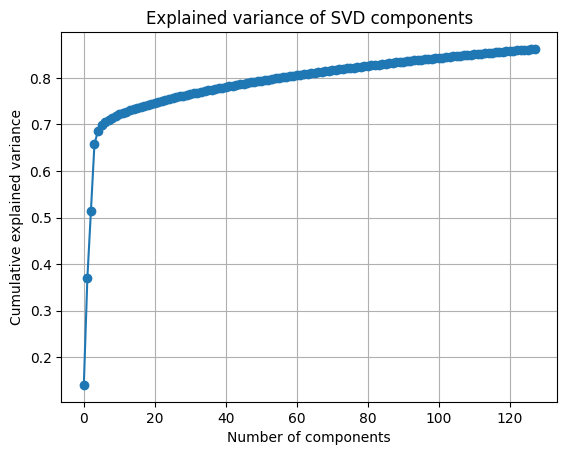

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Fit a singular value decomposition model on our card data
svd = TruncatedSVD(n_components=128, random_state=0)
X_svd = svd.fit_transform(X_cards)


# Examine critical points of SVD performance
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance of SVD components')
plt.grid(True)
plt.show()

In [ ]:
print(f'Total Explained in First 64 Components: {sum(svd.explained_variance_ratio_[:64]) * 100 :.2f}%')
print(f'Total Explained in First 128 Components: {sum(svd.explained_variance_ratio_) * 100:.2f}%')

Total Explained in First 64 Components: 80.89%

Total Explained in First 128 Components: 86.20%

Here we can see that around 80% of the total variance between decks are captured in the first 64 components, and around 86% is captured in 128 components. This massively scales it down from our original ~1.5k dimensions.

**Interpreting The SVD**, do these SVD dimensions represent logical distinctions that make sense?

In [ ]:
import pandas as pd
loadings = pd.DataFrame(
    svd.components_.T,
    index=enc.get_feature_names_out(),
    columns=[f"SVD_{i+1}" for i in range(svd.n_components)]
)

for i in range(5):
    top = loadings[f"SVD_{i+1}"].sort_values(ascending=False).head(12)
    print(f"\n[bold green]Component {i+1}:")
    print("[white]  Top cards:", ', '.join(top.index))

Component 1:

  Top cards: base::Strike, base::Defend, card::Strike_R, card::Defend_G, card::Strike_G, card::Defend_R, 
card::Defend_B, card::Strike_B, base::Bash, card::Bash, base::Survivor, card::Survivor

Component 2:

  Top cards: card::Strike_R, card::Defend_R, base::Bash, card::Bash, base::Strike, base::Shrug It Off, card::Shrug 
It Off, base::Cleave, card::Cleave, card::Flex, base::Flex, card::Pommel Strike

Component 3:

  Top cards: card::Defend_P, base::Defend_P, base::Strike_P, card::Strike_P, card::Vigilance, base::Vigilance, 
base::Eruption, card::Eruption, card::Eruption+1, base::Eruption+1, card::FlurryOfBlows, base::FlurryOfBlows

Component 4:

  Top cards: card::Defend_B, card::Strike_B, card::Dualcast, base::Dualcast, base::Defend, base::Zap, card::Zap, 
base::Strike, base::Ball Lightning, card::Ball Lightning, base::Conserve Battery, card::Conserve Battery

Component 5:

  Top cards: card::Singing Bowl, base::Singing Bowl, card::Bite, base::Bite, card::Ghostly, base::Ghostly, 
base::Madness, card::Madness, base::Bash+1, card::Bash+1, base::Deadly Poison+1, card::Deadly Poison+1

The answer is seemily yes! Component 1 looks to captures the starter cards, including the strikes, defends, and bash!

Then components 2-4 represent the individual classes' specific cards! This also explains why so much of the variance is captured in the first 5 dimensions ~1 per base class.

**Why this might emerge**

Every Class has its own *disjoint* set of cards, so our spare matrix likely looks something like this

```bash
Player Class |  Ironclad cards | Silent cards | Defect cards | Watcher cards |
------------------------------------------------------------------------------
Ironclad     |     dense       |     sparse   |    sparse    |    sparse     |
Silent       |     sparse      |     dense    |    sparse    |    sparse     |
Defect       |     sparse      |     sparse   |    dense     |    sparse     |
Watcher      |     sparse      |     sparse   |    sparse    |    dense      |
```

Which translates to:

| Component | Dominant Positive Loadings                                             | Dominant Negative Loadings                              | Interpretation                                                                                                                              |
| --------- | ---------------------------------------------------------------------- | ------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| **1**     | base::Strike / Defend (all colors)                                     | Upgraded class cards (Impatience+, Brilliance+, Weave+)        | Captures *“base common vs late-game”* contrast: global direction from generic starter decks toward class-specific upgraded decks |
| **2**     | Ironclad staples (Bash, Shrug It Off, Cleave)                          | Silent core cards (Survivor, Neutralize, Poisoned Stab) | **Ironclad vs Silent** axis                                                                                                                 |
| **3**     | Watcher starters (Strike_P, Defend_P, Vigilance, Eruption)             | Ironclad/Silent staples                                 | **Watcher vs rest** axis                                                                                                                    |
| **4**     | Defect starters (Zap, Dualcast)                                        | Ironclad/Silent basics                                  | **Defect vs rest** axis                                                                                                                     |
| **5**     | Scaling Cards (Defragment+, Singing Bowl, Deadly Poison+) | Starter cards                                           | **Advanced deck progression** (meta-deck strength axis)                                                                                     |


**What do the other components represent?**
Speculatively, we can imagine the other components represent how upgraded a card is, or certain niche functionalities (Poison decks, exhaust cards, etc)

## Writes

We'll now store several versions of this data for modeling later:

- 1,000 Runs with 64 and 128 principal component features
- 10,000 Runs with 64 and 128 principal component features
- All 123k Runs with 64 and 128 princiapl component features


In [ ]:
import os
import gc

def write_svd_encoded_df(
    df,
    name: str,
    svd = svd,           # trained 128-component SVD
    enc = enc,           # trained DeckOneHotEncoder
    component_list=(64, 128),
    base_dir='/content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD'
):
  """
  Transform df once using encoder and trained high-dim SVD,
  then write truncated variants (e.g., 64 & 128 components) to Parquet.
  """
  os.makedirs(base_dir, exist_ok=True)
  max_components = max(component_list)

  console.print(f"[blue]Beginning full transform for {name} ({max_components}-component SVD base)")

  # --- One-hot encode once ---
  X_cards = enc.transform(df)
  console.print("[gray]One-hot encoding complete...")

  # --- Single SVD transform ---
  X_svd_full = svd.transform(X_cards)
  console.print(f"[gray]SVD transform complete ({X_svd_full.shape[1]} components)...")

  # --- Metadata block ---
  meta_cols = [
      'run_id','floor','victory','character','asc_level',
      'deck_size','num_relics','max_hp','cur_hp','gold',
      'path_symbol','next_path_symbol','combat_damage','combat_turns'
  ]

  meta_df = df[meta_cols].reset_index(drop=True)

  # --- Write each truncated version ---
  for n in sorted(component_list):
    out_dir = f"{base_dir}/{n}Component"
    os.makedirs(out_dir, exist_ok=True)

    svd_cols = [f"deck_svd_{i:02d}" for i in range(n)]
    svd_df = pd.DataFrame(X_svd_full[:, :n], index=df.index, columns=svd_cols)
    df_out = pd.concat([meta_df, svd_df.reset_index(drop=True)], axis=1)

    path = f"{out_dir}/{name}.parquet"
    df_out.to_parquet(path, index=False, compression="snappy")

    console.print(f"[green]✅ Wrote {n}-component SVD parquet for {name}")
    print(f"Saved {df_out.shape[0]} rows × {df_out.shape[1]} cols → {path}\n")

  # Run garbage collector
  del X_cards, X_svd_full
  gc.collect()
  console.print(f"[cyan]All SVD exports complete for {name}\n")


In [ ]:
write_svd_encoded_df(DATASETS.oneK, name = '1k')

Beginning full transform for 1k (128-component SVD base)

One-hot encoding complete...

SVD transform complete (128 components)...

✅ Wrote 64-component SVD parquet for 1k

Saved 452804 rows × 78 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/64Component/1k.parquet

✅ Wrote 128-component SVD parquet for 1k

Saved 452804 rows × 142 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/128Component/1k.parquet

All SVD exports complete for 1k

In [ ]:
write_svd_encoded_df(DATASETS.tenK, name = '10k')

Beginning full transform for 10k (128-component SVD base)

One-hot encoding complete...

SVD transform complete (128 components)...

✅ Wrote 64-component SVD parquet for 10k

Saved 670221 rows × 78 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/64Component/10k.parquet

✅ Wrote 128-component SVD parquet for 10k

Saved 670221 rows × 142 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/128Component/10k.parquet

All SVD exports complete for 10k

In [ ]:
write_svd_encoded_df(DATASETS.full, name = 'full')

Beginning full transform for full (128-component SVD base)

One-hot encoding complete...

SVD transform complete (128 components)...

✅ Wrote 64-component SVD parquet for full

Saved 3010112 rows × 78 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/64Component/full.parquet

✅ Wrote 128-component SVD parquet for full

Saved 3010112 rows × 142 cols → /content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD/128Component/full.parquet

All SVD exports complete for full